In [1]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scanpy as sc
from tqdm import tqdm
import seaborn as sns
from matplotlib.lines import Line2D
from matplotlib.patches import Patch
import scipy.stats as stats

# CMA aging Atlas: Pancreas
Data downloaded from [Tabula muris senis](https://cellxgene.cziscience.com/collections/0b9d8a04-bb9d-44da-aa27-705bb65b54eb) project. Pancreas data, Smart-seq2 assay in .h5ad format was used for further analysis.

## Importing and preprocessing data

In [4]:
# Import h5ad file in scanpy. 
adata = sc.read_h5ad(input_dir + 'TM_pancreas.h5ad')

# Normalize as CPM (counts per million)
sc.pp.normalize_per_cell(adata, counts_per_cell_after=1e6)

# Transforming CPM into log form
sc.pp.log1p(adata)

## CMA score calculation

In [5]:
# Load matrix file with weight and direction 
model_matrix = pd.read_excel(modelmx)

# Removing EEF1A1 and RAC1 genes because they don't appear in the adata
model_matrix = model_matrix.drop([6, 8], axis=0).reset_index()

# Finding CMA network genes in the dataset
cma_network = adata[:, model_matrix["Ensembl_ms"]]

# Calculating the Zs scores
cma_data_zs = cma_network.copy().X.todense().T

for i in tqdm(np.arange(cma_data_zs.shape[0])):
    
    µ = np.mean(cma_data_zs[i, :])
    sd = np.std(cma_data_zs[i, :])
    
    cma_data_zs[i, :] = (cma_data_zs[i, :] - µ)/sd
    
# Generating a copy of adata.obs to work with
barcode = adata.obs.copy()

# New column in barcode (aka adata.obs) with the CMA scores for each cell detected
for i,j in enumerate(barcode.index):
        
    cell_matrix = model_matrix.copy()

    for g in cell_matrix.index:

        cell_matrix.loc[g, 'gene_count'] = cma_data_zs[g, i]

    cell_matrix['gene_score'] = cell_matrix['gene_count'] * cell_matrix['Direction'] * cell_matrix['Weight']
    score = cell_matrix['gene_score'].sum()/np.sum(cell_matrix['Weight'])

    barcode.loc[j, 'score'] = score   
    

100%|██████████| 16/16 [00:00<00:00, 13538.20it/s]


In [6]:
barcode.head()

,FACS.selection,age,cell,free_annotation,method,donor_id,subtissue,n_genes,n_counts,louvain,...,cell_type,assay,disease,organism,sex,tissue,self_reported_ethnicity,development_stage,observation_joinid,score
index,,,,,,,,,,,,,,,,,,,,,
A10_B000756_B007446_S10.mm10-plus-0-0,Viable,18m,A10_B000756,pancreatic B cell,facs,18_45_M,Endocrine,3212,6392.144043,1,...,type B pancreatic cell,Smart-seq2,normal,Mus musculus,male,pancreas,na,18 month-old stage,K4En@E!h(6,-0.088692
A11_B000756_B007446_S11.mm10-plus-0-0,Viable,18m,A11_B000756,pancreatic B cell,facs,18_45_M,Endocrine,2544,5565.440918,1,...,type B pancreatic cell,Smart-seq2,normal,Mus musculus,male,pancreas,na,18 month-old stage,l~84+$xuu{,-0.003498
A12_B000756_B007446_S12.mm10-plus-0-0,Viable,18m,A12_B000756,nan,facs,18_45_M,Endocrine,3789,4216.151855,3,...,type B pancreatic cell,Smart-seq2,normal,Mus musculus,male,pancreas,na,18 month-old stage,6Y}n#KG|Bw,0.180847
A13_B000756_B007446_S13.mm10-plus-0-0,Viable,18m,A13_B000756,nan,facs,18_45_M,Endocrine,4745,4410.768555,0,...,type B pancreatic cell,Smart-seq2,normal,Mus musculus,male,pancreas,na,18 month-old stage,P;x%D06Oh_,0.034758
A13_B002832_B007443_S13.mm10-plus-0-0,Viable,18m,A13_B002832,pancreatic acinar cell,facs,18_47_F,Exocrine,1050,813.061707,5,...,pancreatic acinar cell,Smart-seq2,normal,Mus musculus,female,pancreas,na,18 month-old stage,I}dYkm9Ltl,-0.714637


## CMA net score/cell type (fold over whole tissue)

In [5]:
# Checking n of mice for Liver
list(barcode['mouse.id'].unique())

['18_45_M',
 '18_47_F',
 '24_60_M',
 '24_61_M',
 '3_8_M',
 '3_10_M',
 '3_39_F',
 '3_38_F']

**Mice n for Liver**
    - Young females: 2
    - Young males: 2
    - Old females: 1
    - Old males: 3

In [7]:
# Generating new ages
for j in barcode.index:    
    if barcode.loc[j, 'age'] == '3m':        
        barcode.loc[j, 'new_age'] = '3m'

    elif barcode.loc[j, 'age'] == '18m':                
        barcode.loc[j, 'new_age'] = '18-24m'

    elif barcode.loc[j, 'age'] == '24m': 
        barcode.loc[j, 'new_age'] = '18-24m'
barcode.head()

,FACS.selection,age,cell,free_annotation,method,donor_id,subtissue,n_genes,n_counts,louvain,...,assay,disease,organism,sex,tissue,self_reported_ethnicity,development_stage,observation_joinid,score,new_age
index,,,,,,,,,,,,,,,,,,,,,
A10_B000756_B007446_S10.mm10-plus-0-0,Viable,18m,A10_B000756,pancreatic B cell,facs,18_45_M,Endocrine,3212,6392.144043,1,...,Smart-seq2,normal,Mus musculus,male,pancreas,na,18 month-old stage,K4En@E!h(6,-0.088692,18-24m
A11_B000756_B007446_S11.mm10-plus-0-0,Viable,18m,A11_B000756,pancreatic B cell,facs,18_45_M,Endocrine,2544,5565.440918,1,...,Smart-seq2,normal,Mus musculus,male,pancreas,na,18 month-old stage,l~84+$xuu{,-0.003498,18-24m
A12_B000756_B007446_S12.mm10-plus-0-0,Viable,18m,A12_B000756,nan,facs,18_45_M,Endocrine,3789,4216.151855,3,...,Smart-seq2,normal,Mus musculus,male,pancreas,na,18 month-old stage,6Y}n#KG|Bw,0.180847,18-24m
A13_B000756_B007446_S13.mm10-plus-0-0,Viable,18m,A13_B000756,nan,facs,18_45_M,Endocrine,4745,4410.768555,0,...,Smart-seq2,normal,Mus musculus,male,pancreas,na,18 month-old stage,P;x%D06Oh_,0.034758,18-24m
A13_B002832_B007443_S13.mm10-plus-0-0,Viable,18m,A13_B002832,pancreatic acinar cell,facs,18_47_F,Exocrine,1050,813.061707,5,...,Smart-seq2,normal,Mus musculus,female,pancreas,na,18 month-old stage,I}dYkm9Ltl,-0.714637,18-24m


In [8]:
# Calculation of net score to 3m using whole tissue CMA score mean
µ = np.mean(barcode[barcode['new_age'] == '3m']['score'])

for i in barcode.index:
    barcode.loc[i, 'net_score'] = barcode.loc[i, 'score'] - µ 

barcode.head()

,FACS.selection,age,cell,free_annotation,method,donor_id,subtissue,n_genes,n_counts,louvain,...,disease,organism,sex,tissue,self_reported_ethnicity,development_stage,observation_joinid,score,new_age,net_score
index,,,,,,,,,,,,,,,,,,,,,
A10_B000756_B007446_S10.mm10-plus-0-0,Viable,18m,A10_B000756,pancreatic B cell,facs,18_45_M,Endocrine,3212,6392.144043,1,...,normal,Mus musculus,male,pancreas,na,18 month-old stage,K4En@E!h(6,-0.088692,18-24m,-0.152319
A11_B000756_B007446_S11.mm10-plus-0-0,Viable,18m,A11_B000756,pancreatic B cell,facs,18_45_M,Endocrine,2544,5565.440918,1,...,normal,Mus musculus,male,pancreas,na,18 month-old stage,l~84+$xuu{,-0.003498,18-24m,-0.067126
A12_B000756_B007446_S12.mm10-plus-0-0,Viable,18m,A12_B000756,nan,facs,18_45_M,Endocrine,3789,4216.151855,3,...,normal,Mus musculus,male,pancreas,na,18 month-old stage,6Y}n#KG|Bw,0.180847,18-24m,0.117219
A13_B000756_B007446_S13.mm10-plus-0-0,Viable,18m,A13_B000756,nan,facs,18_45_M,Endocrine,4745,4410.768555,0,...,normal,Mus musculus,male,pancreas,na,18 month-old stage,P;x%D06Oh_,0.034758,18-24m,-0.028869
A13_B002832_B007443_S13.mm10-plus-0-0,Viable,18m,A13_B002832,pancreatic acinar cell,facs,18_47_F,Exocrine,1050,813.061707,5,...,normal,Mus musculus,female,pancreas,na,18 month-old stage,I}dYkm9Ltl,-0.714637,18-24m,-0.778264


In [8]:
barcode.cell_type.unique()

['type B pancreatic cell', 'pancreatic acinar cell', 'pancreatic A cell', 'pancreatic D cell', 'endothelial cell', 'leukocyte', 'pancreatic ductal cell', 'pancreatic stellate cell', 'pancreatic PP cell']
Categories (9, object): ['endothelial cell', 'leukocyte', 'pancreatic A cell', 'pancreatic D cell', ..., 'pancreatic acinar cell', 'pancreatic ductal cell', 'pancreatic stellate cell', 'type B pancreatic cell']

In [9]:
cells = ['pancreatic acinar cell', 'pancreatic A cell', 'type B pancreatic cell']

## CMA net score/cell type & sex (fold over each cell type young)

In [10]:
# Calculation of net score (fold to 3m for each individual cell type)
for maj_cell in tqdm(np.unique(barcode['cell_type'])):
    
    µ = np.mean(barcode[barcode['cell_type'] == maj_cell][barcode['new_age'] == '3m']['score'])
    
    for cell_index in barcode[barcode['cell_type'] == maj_cell].index:
    
        barcode.loc[cell_index, 'celltype_ns'] = barcode.loc[cell_index, 'score'] - µ  

barcode.head()

100%|██████████| 9/9 [00:00<00:00, 41.42it/s]


,FACS.selection,age,cell,free_annotation,method,donor_id,subtissue,n_genes,n_counts,louvain,...,organism,sex,tissue,self_reported_ethnicity,development_stage,observation_joinid,score,new_age,net_score,celltype_ns
index,,,,,,,,,,,,,,,,,,,,,
A10_B000756_B007446_S10.mm10-plus-0-0,Viable,18m,A10_B000756,pancreatic B cell,facs,18_45_M,Endocrine,3212,6392.144043,1,...,Mus musculus,male,pancreas,na,18 month-old stage,K4En@E!h(6,-0.088692,18-24m,-0.152319,-0.199832
A11_B000756_B007446_S11.mm10-plus-0-0,Viable,18m,A11_B000756,pancreatic B cell,facs,18_45_M,Endocrine,2544,5565.440918,1,...,Mus musculus,male,pancreas,na,18 month-old stage,l~84+$xuu{,-0.003498,18-24m,-0.067126,-0.114639
A12_B000756_B007446_S12.mm10-plus-0-0,Viable,18m,A12_B000756,nan,facs,18_45_M,Endocrine,3789,4216.151855,3,...,Mus musculus,male,pancreas,na,18 month-old stage,6Y}n#KG|Bw,0.180847,18-24m,0.117219,0.069706
A13_B000756_B007446_S13.mm10-plus-0-0,Viable,18m,A13_B000756,nan,facs,18_45_M,Endocrine,4745,4410.768555,0,...,Mus musculus,male,pancreas,na,18 month-old stage,P;x%D06Oh_,0.034758,18-24m,-0.028869,-0.076382
A13_B002832_B007443_S13.mm10-plus-0-0,Viable,18m,A13_B002832,pancreatic acinar cell,facs,18_47_F,Exocrine,1050,813.061707,5,...,Mus musculus,female,pancreas,na,18 month-old stage,I}dYkm9Ltl,-0.714637,18-24m,-0.778264,-0.351906


### Graphs

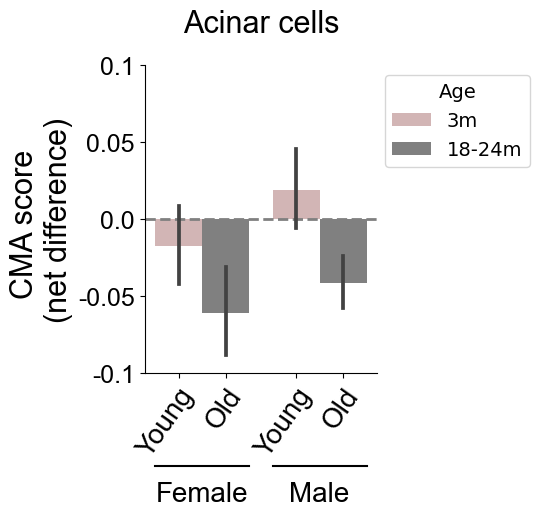

In [11]:
# Figure Acinar
fig, ax = plt.subplots(figsize=(3,4))
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
hfont = {'fontname':'Arial'}

sns.barplot(x='sex', y='celltype_ns', data=barcode[barcode.cell_type==cells[0]], 
            hue='new_age', order=["female", "male"], hue_order=['3m', "18-24m"], palette=['#D7B0B0', '#808080'], ci=68)

plt.axhline(y=0, linestyle='dashed', linewidth=2, color='gray', zorder=1)
plt.xlabel('')
plt.ylabel('CMA score \n(net difference)', fontdict={'family':'Arial', 'size': 22})
ax.set_xticks([-0.2, 0.2, 0.8, 1.2])
ax.set_xticklabels(["Young", "Old", "Young", "Old"], fontdict={'family':'Arial', 'size': 20}, 
                   rotation=55, ha='right', rotation_mode='anchor')
plt.ylim(-0.10, 0.10)
ax.set_yticks([-0.10, -0.05, 0.00, 0.05, 0.10])
ax.set_yticklabels([-0.10, -0.05, 0.00, 0.05, 0.10], fontdict={'family':'Arial', 'size': 18})
h, l = ax.get_legend_handles_labels()
ax.legend(h, ['3m', "18-24m"], bbox_to_anchor=(1.7, 1), title="Age", title_fontsize = "14", fontsize = 14)
plt.title(label='Acinar cells', fontdict={'family':'Arial', 'size': 22}, y=1.08)
 
# Female & male
trans = ax.get_xaxis_transform()
ax.annotate('Female', xy=(0, -.35), xycoords=trans, ha="center", va="top", size=20, **hfont)
ax.plot([-.4,0.4],[-.3,-.3], color="k", transform=trans, clip_on=False)
ax.annotate('Male', xy=(1, -.35), xycoords=trans, ha="center", va="top", size=20, **hfont)
ax.plot([0.6,1.4],[-.3,-.3], color="k", transform=trans, clip_on=False)

plt.savefig(output_dir + '/Acin_cellns_sex.png',bbox_inches='tight', dpi=300)

plt.show()

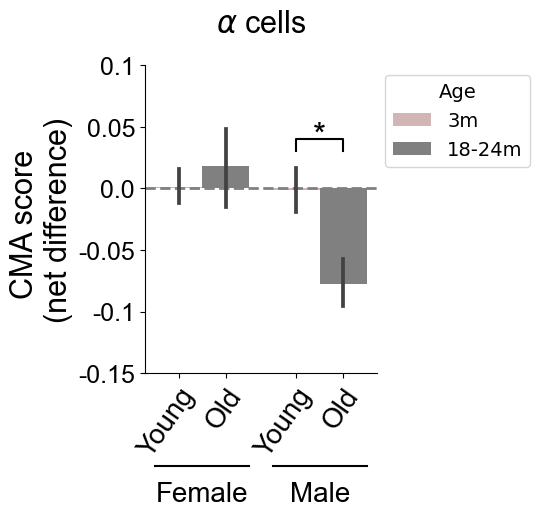

In [12]:
# Figure Alpha cells
fig, ax = plt.subplots(figsize=(3,4))
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
hfont = {'fontname':'Arial'}

sns.barplot(x='sex', y='celltype_ns', data=barcode[barcode.cell_type==cells[1]], 
            hue='new_age', order=["female", "male"], hue_order=['3m', "18-24m"], palette=['#D7B0B0', '#808080'], ci=68)

plt.axhline(y=0, linestyle='dashed', linewidth=2, color='gray', zorder=1)
plt.xlabel('')
plt.ylabel('CMA score \n(net difference)', fontdict={'family':'Arial', 'size': 22})
ax.set_xticks([-0.2, 0.2, 0.8, 1.2])
ax.set_xticklabels(["Young", "Old", "Young", "Old"], fontdict={'family':'Arial', 'size': 20}, 
                   rotation=55, ha='right', rotation_mode='anchor')
plt.ylim(-0.15, 0.10)
ax.set_yticks([-0.15, -0.10, -0.05, 0.00, 0.05, 0.10])
ax.set_yticklabels([-0.15, -0.10, -0.05, 0.00, 0.05, 0.10], fontdict={'family':'Arial', 'size': 18})
h, l = ax.get_legend_handles_labels()
ax.legend(h, ['3m', "18-24m"], bbox_to_anchor=(1.7, 1), title="Age", title_fontsize = "14", fontsize = 14)
plt.title(label=r'$\alpha$ cells', fontdict={'family':'Arial', 'size': 22}, y=1.08)
 

# statistical annotation
x1, x2 = 0.8, 1.2   
y, h, col = 0.03 , 0.01, 'k'
plt.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, c=col)
plt.text((x1+x2)*.5, y, "*", ha='center', va='bottom', color=col, fontdict={'family':'Arial', 'size': 24})

# Female & male
trans = ax.get_xaxis_transform()
ax.annotate('Female', xy=(0, -.35), xycoords=trans, ha="center", va="top", size=20, **hfont)
ax.plot([-.4,0.4],[-.3,-.3], color="k", transform=trans, clip_on=False)
ax.annotate('Male', xy=(1, -.35), xycoords=trans, ha="center", va="top", size=20, **hfont)
ax.plot([0.6,1.4],[-.3,-.3], color="k", transform=trans, clip_on=False)

plt.savefig(output_dir + '/A_cellns_sex.png',bbox_inches='tight', dpi=300)

plt.show()

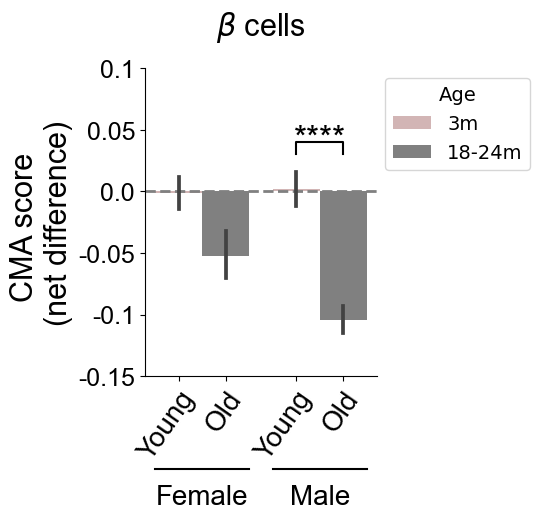

In [13]:
# Figure Beta cells
fig, ax = plt.subplots(figsize=(3,4))
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
hfont = {'fontname':'Arial'}

sns.barplot(x='sex', y='celltype_ns', data=barcode[barcode.cell_type==cells[2]], 
            hue='new_age', order=["female", "male"], hue_order=['3m', "18-24m"], palette=['#D7B0B0', '#808080'], ci=68)

plt.axhline(y=0, linestyle='dashed', linewidth=2, color='gray', zorder=1)
plt.xlabel('')
plt.ylabel('CMA score \n(net difference)', fontdict={'family':'Arial', 'size': 22})
ax.set_xticks([-0.2, 0.2, 0.8, 1.2])
ax.set_xticklabels(["Young", "Old", "Young", "Old"], fontdict={'family':'Arial', 'size': 20}, 
                   rotation=55, ha='right', rotation_mode='anchor')
plt.ylim(-0.15, 0.10)
ax.set_yticks([-0.15, -0.10, -0.05, 0.00, 0.05, 0.10])
ax.set_yticklabels([-0.15, -0.10, -0.05, 0.00, 0.05, 0.10], fontdict={'family':'Arial', 'size': 18})
h, l = ax.get_legend_handles_labels()
ax.legend(h, ['3m', "18-24m"], bbox_to_anchor=(1.7, 1), title="Age", title_fontsize = "14", fontsize = 14)
plt.title(label=r'$\beta$ cells', fontdict={'family':'Arial', 'size': 22}, y=1.08)
 

# statistical annotation
x1, x2 = 0.8, 1.2   
y, h, col = 0.03 , 0.01, 'k'
plt.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, c=col)
plt.text((x1+x2)*.5, y, "****", ha='center', va='bottom', color=col, fontdict={'family':'Arial', 'size': 24})

# Female & male
trans = ax.get_xaxis_transform()
ax.annotate('Female', xy=(0, -.35), xycoords=trans, ha="center", va="top", size=20, **hfont)
ax.plot([-.4,0.4],[-.3,-.3], color="k", transform=trans, clip_on=False)
ax.annotate('Male', xy=(1, -.35), xycoords=trans, ha="center", va="top", size=20, **hfont)
ax.plot([0.6,1.4],[-.3,-.3], color="k", transform=trans, clip_on=False)

plt.savefig(output_dir + '/B_cellns_sex.png',bbox_inches='tight', dpi=300)

plt.show()

### Raw data

In [14]:
# Extracting raw values for bar graphs graphic
def raw (tipos, edad, sex):
    long = []
    celula = []
    age = []
    mean=[]
    sem=[]
    sexo = []

    for i in tipos:
        for x in edad:
            for y in sex:
                n = len(barcode[barcode['cell_type']== i][barcode['new_age']== x][barcode['sex']== y].index)
                m = np.mean(barcode[barcode['cell_type']== i][barcode['new_age']== x][barcode['sex']== y]['celltype_ns'])
                s = stats.sem(barcode[barcode['cell_type']== i][barcode['new_age']== x][barcode['sex']== y]['celltype_ns'])

                long.append(n)
                celula.append(i)                
                age.append(x)
                sexo.append(y)
                mean.append(m)
                sem.append(s)

    df_raw = pd.DataFrame({"Cell_type": celula, "Age": age, "Sex":sexo, "n": long, "Mean":mean, "SEM": sem})
    df_raw.to_excel(output_dir + "/Panc_Raw_data.xlsx", sheet_name="CellNsbysex", index=False)
    
    return(df_raw)

In [15]:
raw(tipos = cells, edad=['3m', '18-24m'], sex=['female', 'male'])

,Cell_type,Age,Sex,n,Mean,SEM
0,pancreatic acinar cell,3m,female,100,-0.017506,0.025501
1,pancreatic acinar cell,3m,male,91,0.019237,0.025995
2,pancreatic acinar cell,18-24m,female,118,-0.060920,0.029291
3,pancreatic acinar cell,18-24m,male,267,-0.041282,0.016744
4,pancreatic A cell,3m,female,181,0.001462,0.013875
5,pancreatic A cell,3m,male,183,-0.001446,0.017474
6,pancreatic A cell,18-24m,female,41,0.018377,0.031274
7,pancreatic A cell,18-24m,male,116,-0.077723,0.019509
8,type B pancreatic cell,3m,female,281,-0.001450,0.012920
9,type B pancreatic cell,3m,male,241,0.001690,0.014090


## CMA network heatmaps by cell type & sex

In [16]:
# Load matrix reordered
model_matrix = pd.read_excel(modelmx, 'reordered')

# Removing EEF1A1 and RAC1 because they don't appear in the adata
model_matrix = model_matrix.drop([6, 8], axis=0).reset_index()

# Mapping data from adata to new order of CMA network
cma_network = adata[:, model_matrix["Ensembl_ms"]]

# GFAP does not appear in some cell types, creating a list without it
nogfap = ['LAMP2', 'HSPA8', 'HSP90AA1', 'HSP90AB1', 'DNAJB1', 'PHLPP1', 'NFATC1', 'NCOR1', 'NFE2L2', 'RAB11A', 
          'RICTOR', 'AKT1', 'AKT2', 'CTSA', 'RARA']

In [18]:
def sex_heatmaps(cellpop):
    
    # Prepare empty matrix
    matrix = np.zeros((16, 4))
    
    #Find cell indices for each condition
    female_3m = list(barcode[barcode['cell_type'] == cellpop][barcode['sex'] == "female"][barcode['new_age'] == "3m"].index)
    female_18_24m = list(barcode[barcode['cell_type'] == cellpop][barcode['sex'] == "female"][barcode['new_age'] == "18-24m"].index)
    male_3m = list(barcode[barcode['cell_type'] == cellpop][barcode['sex'] == "male"][barcode['new_age'] == "3m"].index)
    male_18_24m = list(barcode[barcode['cell_type'] == cellpop][barcode['sex'] == "male"][barcode['new_age'] == "18-24m"].index)
    
    #Calculate mean per gene for every condition
    for rank in tqdm(np.arange(matrix.shape[0])):    
        matrix[rank, 0] = np.mean(cma_network[female_3m, :].X.todense()[:, rank])
        matrix[rank, 1] = np.mean(cma_network[female_18_24m, :].X.todense()[:, rank])
        matrix[rank, 2] = np.mean(cma_network[male_3m, :].X.todense()[:, rank])
        matrix[rank, 3] = np.mean(cma_network[male_18_24m, :].X.todense()[:, rank])
            
    #Perform z-scoring on each row
    matrix_zs = matrix.copy()

    for i in np.arange(matrix_zs.shape[0]):
    
        µ = np.mean(matrix_zs[i, :])
        sd = np.std(matrix_zs[i, :])
    
        matrix_zs[i, :] = (matrix_zs[i, :] - µ) / sd     
    
    # Saving raw data
    df_m = pd.DataFrame(matrix_zs, columns=['female_young', 'female_old', 'male_young', 'male_old'], 
                        index=model_matrix['Gene name'])
    with pd.ExcelWriter(output_dir + "/Panc_Raw_data.xlsx", mode="a", if_sheet_exists='replace',
                        engine="openpyxl") as writer:
        df_m.to_excel(writer, sheet_name=cellpop[:3]+'_heat', index=True)
        
    #Plot heatmap removing GFAP
    if cellpop == cells[1] or cellpop == cells[2]:
        matrix_zs = np.delete(matrix_zs,(5), axis=0)
        fig, ax = plt.subplots(figsize=(6,6))
        hfont = {'fontname':'Arial'}
        plt.imshow(matrix_zs, cmap='viridis', vmin=-1.5, vmax=1.5) 
        plt.colorbar(shrink=.5).set_label(label="Gene Z score", size=16, **hfont)

        plt.yticks(np.arange(15), nogfap, fontsize=16, **hfont)

        plt.ylim(14.5, -0.5)

        plt.xticks(np.arange(4), ['3m', '18-24m', '3m', '18-24m'], rotation=55, ha='right', rotation_mode='anchor',fontsize=16, **hfont)
        
        if cellpop == cells[1]:
            plt.title(r'$\alpha$ cells', fontdict={'family':'Arial', 'size': 22}, y=1.05)
        elif cellpop == cells[2]:
            plt.title(r'$\beta$ cells', fontdict={'family':'Arial', 'size': 22}, y=1.05)
            
        plt.axvline(x=1.5, linestyle='dashed', linewidth=2, color='k', zorder=1)
        
        # Annotations
        trans = ax.get_yaxis_transform()
        trans2 = ax.get_xaxis_transform()
        ax.annotate('Effectors', xy=(-1.5, 0.25), xycoords=trans, ha='left', rotation=90, va="top", 
                    color='k', size=16, **hfont)
        ax.plot([-1.25,-1.25],[-0.25, 4.25], color="k", transform=trans, clip_on=False)
        ax.annotate('Pos. regulators', xy=(-1.5, 4.5), xycoords=trans, ha='left', rotation=90, va="top", 
                    color='green', size=16, **hfont)
        ax.plot([-1.25,-1.25],[4.75, 9.25], color="k", transform=trans, clip_on=False)
        ax.annotate('Neg. regulators', xy=(-1.5, 9.75), xycoords=trans, ha='left', rotation=90, va="top", 
                    color='red', size=16, **hfont)
        ax.plot([-1.25,-1.25],[10, 14.25], color="k", transform=trans, clip_on=False)
        ax.annotate('Female', xy=(0.4, -.22), xycoords=trans2, ha="center", va="top", size=16, **hfont)
        ax.plot([-.5,1.25],[-.2,-.2], color="k", transform=trans2, clip_on=False)

        ax.annotate('Male', xy=(2.6, -.22), xycoords=trans2, ha="center", va="top", size=16, **hfont)
        ax.plot([1.5, 3.25],[-.2,-.2], color="k", transform=trans2, clip_on=False)
        
    else: # including GFAP
        fig, ax = plt.subplots(figsize=(6,6))
        hfont = {'fontname':'Arial'}

        plt.imshow(matrix_zs, cmap='viridis', vmin=-1.5, vmax=1.5)
        plt.colorbar(shrink=.5).set_label(label="Gene Z score", size=16, **hfont)

        plt.yticks(np.arange(16), model_matrix['Gene name'], fontsize=16, **hfont)

        plt.ylim(15.5, -0.5)

        plt.xticks(np.arange(4), ['3m', '18-24m', '3m', '18-24m'], rotation=55, ha='right', rotation_mode='anchor',fontsize=16, **hfont)
        plt.title('Acinar cells', fontdict={'family':'Arial', 'size': 22}, y=1.05)

        plt.axvline(x=1.5, linestyle='dashed', linewidth=2, color='k', zorder=1)

        # Annotations
        trans = ax.get_yaxis_transform()
        trans2 = ax.get_xaxis_transform()
        ax.annotate('Effectors', xy=(-1.5, 0), xycoords=trans, ha='left', rotation=90, va="top", 
                    color='k', size=16, **hfont)
        ax.plot([-1.25,-1.25],[-0.25, 4.25], color="k", transform=trans, clip_on=False)

        ax.annotate('Pos. regulators', xy=(-1.5, 4.75), xycoords=trans, ha='left', rotation=90, va="top", 
                    color='green', size=16, **hfont)
        ax.plot([-1.25,-1.25],[4.75, 10.25], color="k", transform=trans, clip_on=False)

        ax.annotate('Neg. regulators', xy=(-1.5, 10.5), xycoords=trans, ha='left', rotation=90, va="top", 
                    color='red', size=16, **hfont)
        ax.plot([-1.25,-1.25],[11, 15.25], color="k", transform=trans, clip_on=False)

        ax.annotate('Female', xy=(0.4, -.22), xycoords=trans2, ha="center", va="top", size=16, **hfont)
        ax.plot([-.5,1.25],[-.2,-.2], color="k", transform=trans2, clip_on=False)

        ax.annotate('Male', xy=(2.6, -.22), xycoords=trans2, ha="center", va="top", size=16, **hfont)
        ax.plot([1.5, 3.25],[-.2,-.2], color="k", transform=trans2, clip_on=False)
    
    plt.savefig(output_dir + '/{}_heat.png'.format(cellpop[:3]), bbox_inches='tight', dpi=300)
    
    plt.show()

100%|██████████| 16/16 [00:00<00:00, 45.46it/s]


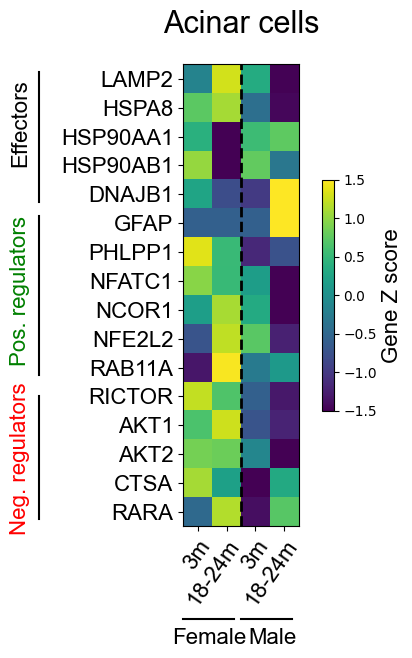

100%|██████████| 16/16 [00:00<00:00, 36.29it/s]


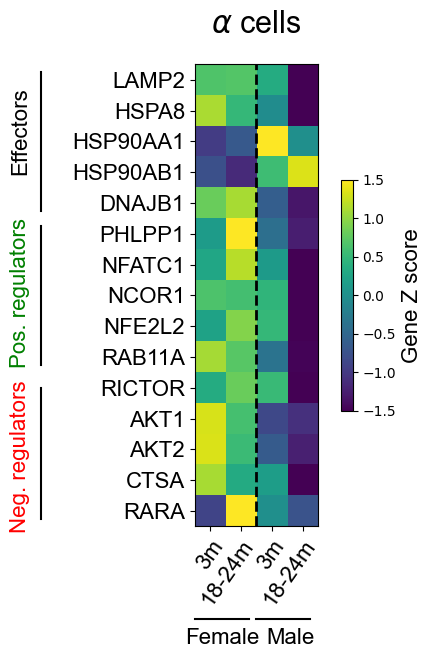

100%|██████████| 16/16 [00:00<00:00, 21.19it/s]


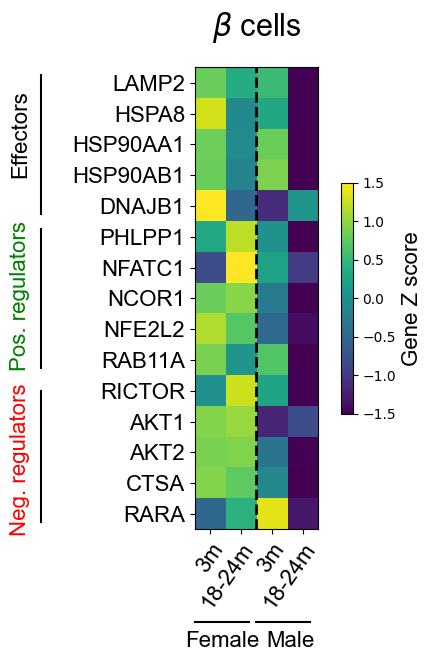

In [19]:
for i in cells:
    sex_heatmaps(cellpop=i)